# Unicode Distribution Creation
The purpose of this project is to demonstrate how a set of unicode characters can be turned into a probability distribution for sampling from. The goal is to create a ipython magic function so this can be done easily. For example the following code would create a close to normal distribution object:
```
%%ascii_dist
   _____
  /     \
 /       \
/         \
```

In [103]:
# The general approach we are taking is as follows:
# 1. Render the unicode characters as an image using PILLOW
# 2. Consider the image to be a histogram and determine bin counts with missing data
# 3. Interpolate data with pandas so the data is continuous
# 4. Change this into a distribution that can be sampled from
# 5. Stretch goal: Implement smoothing using rolling window
#
# See https://asc-paint.glitch.me/ as a way to create fancy ANSI curves

from IPython.core.magic import register_cell_magic

@register_cell_magic
def ascii_dist(line, cell):
    return ASCIIDistribution(cell)

In [139]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from zipfile import ZipFile

class ASCIIDistribution:
    """Represents a probability distribution based on an ASCII diagram"""
        
    def __init__(self, ascii_data, frequency='1S'):
        self.df = None
        
        # TODO: figure out how big the canvas should be from the size of the text entered
        img=Image.new("L", (500,250), color=255)

        # TODO: consider making the font choice an option, and choose size based on canvas descision
        with ZipFile('Source_Code_Pro.zip', 'r') as font_zip:
            with font_zip.open('SourceCodePro-Medium.ttf') as ttf_file:    
                scp_font=ImageFont.truetype(ttf_file,size=48)

        # Create drawing object and render our text
        dr=ImageDraw.Draw(img)
        dr=dr.text((0,0), ascii_data, font=scp_font)
        
        # render image to screen
        #display(img)

        WHITE_PIXEL_VALUE=255

        # calculate the values along the x axis of the number of white pixels under the curve or set
        # the value to None if there is no curve present at a given location
        pixels=[]
        for x in range(img.size[0]):
            num_white_pixels=0
            for y in range(img.size[1]):
                if img.getpixel((x,img.size[1]-1-y)) != WHITE_PIXEL_VALUE:
                    break
                num_white_pixels+=1
            if num_white_pixels==img.size[1]:
                pixels.append(None)
            else:
                pixels.append(num_white_pixels)

        # convert list to pandas to clean up distribution
        pixels=pd.Series(pixels)
        # trim the start and end of the pixel series from nans
        pixels=pixels[~pixels.isna()]
        # add back in gaps as nans by resampling to a secon frequency
        pixels.index=pd.to_datetime(pixels.index,unit='s')
        pixels=pixels.resample(frequency).asfreq()

        # interpolate to make distribution continuous
        pixels=pixels.interpolate(limit_direction="both")

        # smooth data with rolling window
        # TODO: Need to determine the size of the window based on size of the image/data
        pixels=pixels.rolling(25,min_periods=1,center=True).mean()

        # TODO: the date time index isn't needed any more so we should drop that back to integers?
        # TODO: we need to generate the probability of a given point being chosen and put that in df["prob"]
        # TODO: we need to generate the cummulative probability of a given point and put that in df["cum_prob"]
        # TODO: then we pull out np.random.uniform() and find the closest point in df["cum_prob"] to that
        # what's a good way to do this? lame way: np.min(np.abs(df["cum_prob"]-rando_num)) ??? 
        # Then we want to pull out that number's index. hrm.

        df=pd.DataFrame(pixels,columns=["datapoints"])
        df["prob"]=df["datapoints"]/df["datapoints"].sum()
        df["cumprob"]=df["prob"].cumsum()

        self.df=df

    def sample(self):
        target=np.random.uniform()
        options=np.abs(self.df["cumprob"]-target)
        return (options[options==np.min(options)].index[0]-options.index[0]).total_seconds()/len(options)


In [105]:
%%ascii_dist
   _____
  /     \
 /       \
/         \


In [134]:
len(x.df)

300001

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d99fd550>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d943c710>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d9544940>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8da3a6b70>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8da0a27f0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d8e20fd0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d8ced240>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d8bac470>]],
      dtype=object)

1.19 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


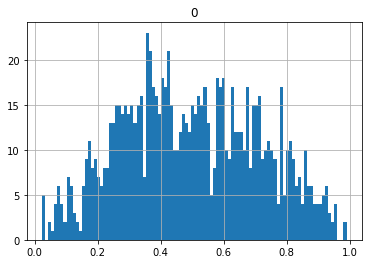

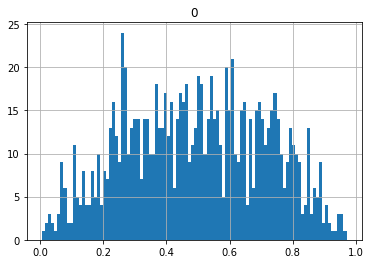

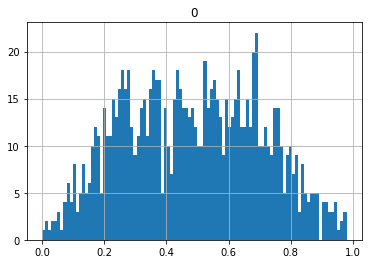

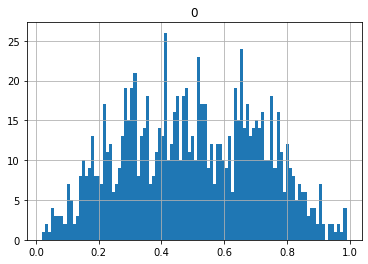

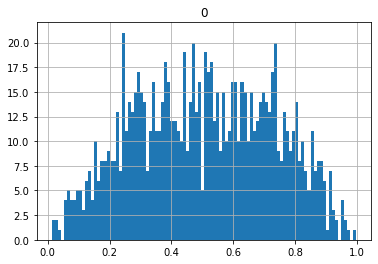

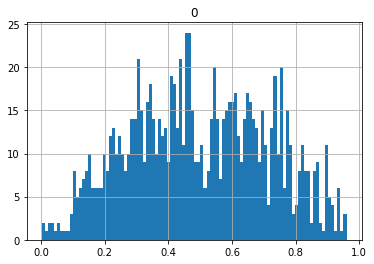

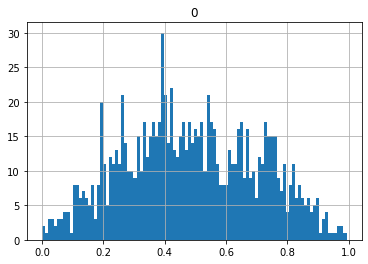

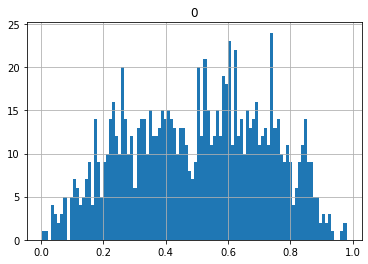

In [142]:
%%timeit
s=r'''
   _____
  /     \
 /       \
/         \ '''

x=ASCIIDistribution(s)
#for j in range(0,5):
display(pd.DataFrame([x.sample() for i in range(0,1000)]).hist(bins=100))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8da983710>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8dcf82470>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d9841f98>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d99881d0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d986bba8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d9fa11d0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d9e27400>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d918d630>]],
      dtype=object)

4.75 s ± 510 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


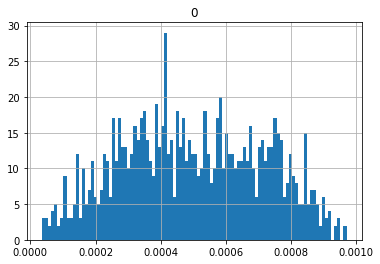

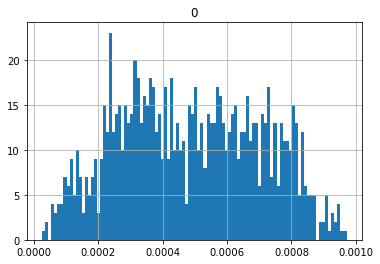

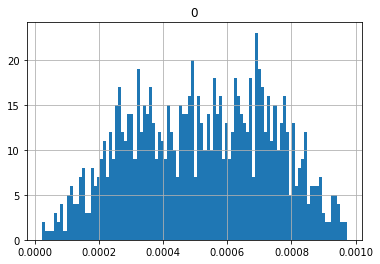

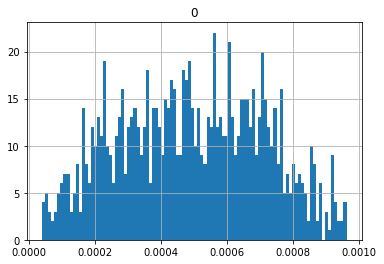

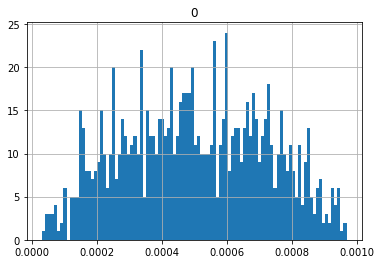

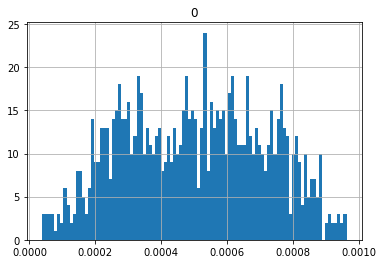

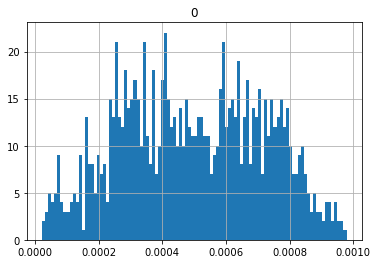

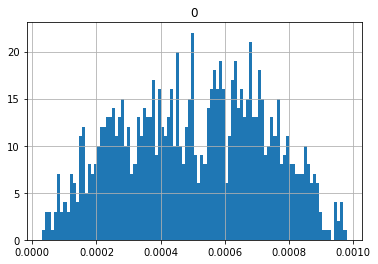

In [143]:
%%timeit
s=r'''
   _____
  /     \
 /       \
/         \ '''

x=ASCIIDistribution(s,frequency='1ms')
#for j in range(0,5):
display(pd.DataFrame([x.sample() for i in range(0,1000)]).hist(bins=100))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d90e0be0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d90f72e8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d9082e10>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d8fda978>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8d8fa5a20>]],
      dtype=object)

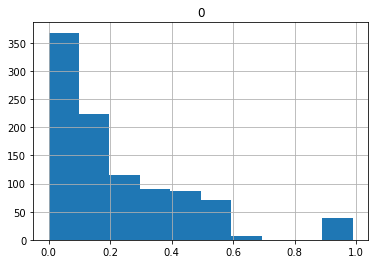

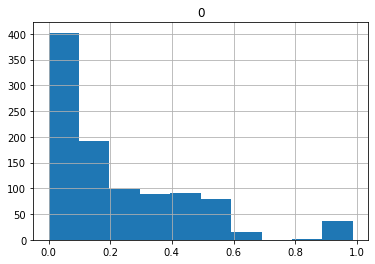

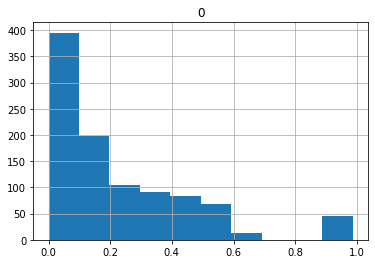

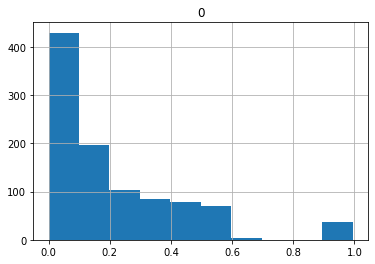

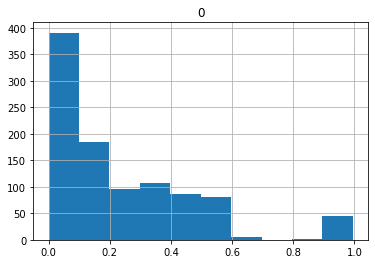

In [129]:
s=r'''
\    
 \
  \
        \___/\ '''

x=ASCIIDistribution(s)
for j in range(0,5):
    display(pd.DataFrame([x.sample() for i in range(0,1000)]).hist(bins=10))